In [6]:
import numpy as np 
import pandas as pd
import os, time, sys
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten # type: ignore
import importlib
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import dnn
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Loading a digit

##### Changing N affects the 'resolution' of the Fourier transform: how pixelated our FT is
##### Changing sampling of the object affects how 'wide' is out FT (in frequency domain AND also in the real space if it was a lens)

Fixed parameters:
simulation parameters:magIn=0.7, δout=0.78μm
metasurface parameters: Nmeta=56, neuron size=1μm, Dmeta=56μm
optical setup: f=20.0mm, λ=1.55μm
Following parameters:
N=103, δin=387.5 μm
Dobj=10.85 mm


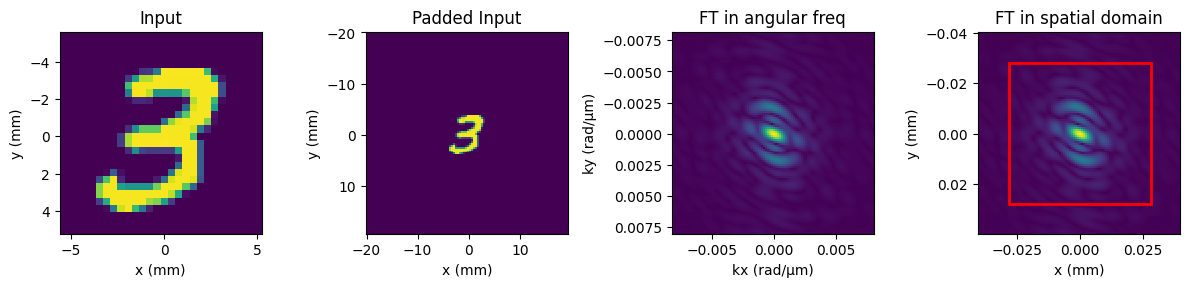

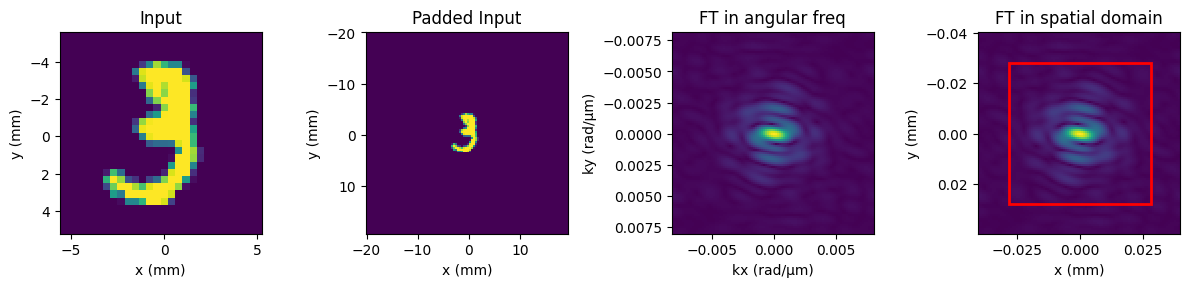

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import dnn  # your own module for loading data

# === CONFIGURATION ===
magIn=0.7  
Nmeta=56
neuron_size=1 # µm
Dmeta=Nmeta*neuron_size
D=Dmeta/magIn
f = 20000  
wavelength = 1.55    
sample_out=wavelength/2
N=round(D/sample_out)
sample_size=wavelength*f/D
print('Fixed parameters:')
print(f'simulation parameters:magIn={magIn}, δout={np.round(sample_out,2)}μm')
print(f'metasurface parameters: Nmeta={Nmeta}, neuron size={neuron_size}μm, Dmeta={np.round(Dmeta,2)}μm')
print(f'optical setup: f={f*1e-3}mm, λ={wavelength}μm')
print('Following parameters:')
print(f'N={N}, δin={np.round(sample_size,2)} μm')
print(f'Dobj={np.round(28*sample_size*1e-3,2)} mm')

# === LOAD DATA ===
x_train, y_train, _, _ = dnn.loadData("digits")
digit=3
x_train_ones = x_train[y_train == digit][:2]
y_train_ones = y_train[y_train == digit][:2]
N_obj = x_train_ones[0].shape[0]



# === FUNCTIONS ===

def pad_image(image, target_size):
    pad = target_size - image.shape[0]
    return np.pad(image,
                  pad_width=((pad // 2, pad // 2), (pad // 2, pad // 2)),
                  mode='constant', constant_values=0)

def get_spatial_coords(N, dx):
    x = np.linspace(-N // 2, N // 2 - 1, N) * dx*1e-3
    return np.meshgrid(x, x) #in mm

def compute_fft(image, dx):
    fft2 = np.fft.fft2(image)
    fft2_shifted = np.fft.fftshift(fft2)
    magnitude = np.abs(fft2_shifted)

    fx = np.fft.fftshift(np.fft.fftfreq(image.shape[0], d=dx))
    fy = np.fft.fftshift(np.fft.fftfreq(image.shape[1], d=dx))
    kx = 2 * np.pi * fx
    ky = 2 * np.pi * fy
    return magnitude, fx, fy, kx, ky

def get_fourier_plane_coords(fx, fy, wavelength, focal_length):
    x_prime = wavelength * focal_length * fx
    y_prime = wavelength * focal_length * fy
    return np.meshgrid(x_prime * 1e-3, y_prime * 1e-3)  # mm
# === COMPUTATION ===
for i in range(len(x_train_ones)):
    sample_image=x_train_ones[i]
    sample_label=y_train_ones[i]

    # Original
    X_obj, Y_obj = get_spatial_coords(N_obj, sample_size)

    # Padding
    padded_image = pad_image(sample_image, N)
    X_pad, Y_pad = get_spatial_coords(N, sample_size)

    # Fourier Domain
    magnitude, fx, fy, kx, ky = compute_fft(padded_image, sample_size)
    KX, KY = np.meshgrid(kx, ky)

    # Fourier Plane (real-space, after lens)
    X_prime, Y_prime = get_fourier_plane_coords(fx, fy, wavelength, f)

    # === PLOTTING ===

    fig, ax = plt.subplots(1, 4, figsize=(12, 4))

    # (1) Original
    ax[0].pcolormesh(X_obj, Y_obj, sample_image, shading='auto')
    ax[0].set_title("Input")
    ax[0].set_xlabel("x (mm)")
    ax[0].set_ylabel("y (mm)")

    # (2) Padded
    ax[1].pcolormesh(X_pad, Y_pad, padded_image, shading='auto')
    ax[1].set_title("Padded Input")
    ax[1].set_xlabel("x (mm)")
    ax[1].set_ylabel("y (mm)")

    # (3) FFT (kx, ky)
    ax[2].pcolormesh(KX, KY, magnitude, shading='auto')
    ax[2].set_title("FT in angular freq")
    ax[2].set_xlabel("kx (rad/μm)")
    ax[2].set_ylabel("ky (rad/μm)")

    # (4) Fourier plane image
    ax[3].pcolormesh(X_prime, Y_prime, magnitude, shading='auto')
    ax[3].set_title("FT in spatial domain")
    ax[3].set_xlabel("x (mm)")
    ax[3].set_ylabel("y (mm)")

    # Add metasurface rectangle in mm
    x0 = -Nmeta / 2 * neuron_size*1e-3
    y0 = -Nmeta / 2 * neuron_size*1e-3
    rect = Rectangle((x0, y0), Nmeta * neuron_size*1e-3, Nmeta * neuron_size*1e-3,
                    edgecolor='red', facecolor='none', linewidth=2)
    ax[3].add_patch(rect)

    # Formatting
    for a in ax:
        a.set_aspect('equal')
        a.invert_yaxis()

    plt.tight_layout()
    plt.show()
